In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:38581")
client

Client Scheduler: tcp://127.0.0.1:38581 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 40 Memory: 168.99 GB


In [2]:
import numpy as np
import xarray as xr
import os.path as op
from xmitgcm import open_mdsdataset
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/'
topog = '/tank/topog/tuchida/TWA/'
tdgs = '/tank/tdgs/tuchida/TWA/'

In [3]:
ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                             % (0,1963)), 
                     grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                     prefix=['diag_ocnTave','diag_ocnSurf'], 
                     delta_t=2e2, iters=790560
                    )
ds

<xarray.Dataset>
Dimensions:  (XC: 1000, XG: 1000, YC: 900, YG: 900, Z: 46, Zl: 46, Zp1: 47, Zu: 46, time: 1)
Coordinates: (12/33)
    iter     (time) int64 790560
  * time     (time) timedelta64[ns] 1830 days
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * XG       (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9
  * YG       (YG) >f4 -19.96 -19.87 -19.79 -19.71 ... 54.71 54.79 54.88 54.96
    ...       ...
    maskW    (Z, YC, XG) bool dask.array<chunksize=(46, 900, 1000), meta=np.ndarray>
    maskS    (Z, YG, XC) bool dask.array<chunksize=(46, 900, 1000), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(900, 1000), meta=np.ndarray>
    rhoRef   (Z) >f4 1.021e+03 1.021e+03 1.021e+03 ... 1.044e+03 1.044e+03
    maskInW  (YC, XG) bool dask.array<chunksize=(900, 1000), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(900, 1000), meta=np.ndarray>
Data variables:
    ETAN     (time, YC, XC) >f4 dask.array<chunksize=(1, 900, 1000), meta=np.ndarray>
    THETA    (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 46, 900, 1000), meta=np.ndarray>
    SALT     (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 46, 900, 1000), meta=np.ndarray>
    UVEL     (time, Z, YC, XG) >f4 dask.array<chunksize=(1, 46, 900, 1000), meta=np.ndarray>
    VVEL     (time, Z, YG, XC) >f4 dask.array<chunksize=(1, 46, 900, 1000), meta=np.ndarray>
    WVEL     (time, Zl, YC, XC) >f4 dask.array<chunksize=(1, 46, 900, 1000), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/tank/chaocea...

In [4]:
# set format of binary files 
tp = '>f4'

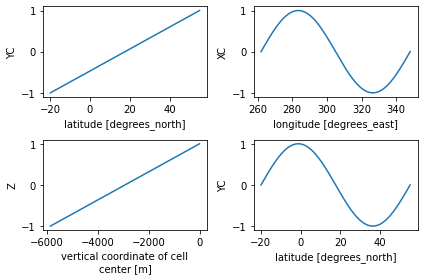

In [5]:
ptr0 = 2*(ds.YC - ds.YC.mean(skipna=True))/(ds.YC.max(skipna=True)-ds.YC.min(skipna=True))
ptr1 = np.sin(2*np.pi*(ds.XC-ds.XC.min(skipna=True))/(ds.XC.max(skipna=True)-ds.XC.min(skipna=True)))
ptr2 = 2*(ds.Z - ds.Z.min(skipna=True)/2)/(ds.Z.max(skipna=True)-ds.Z.min(skipna=True)) 
ptr3 = np.sin(2*np.pi*(ds.YC-ds.YC.min(skipna=True))/(ds.YC.max(skipna=True)-ds.YC.min(skipna=True)))

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_tight_layout(True)
ptr0.plot(ax=axes[0,0])
ptr1.plot(ax=axes[0,1])
ptr2.plot(ax=axes[1,0])
ptr3.plot(ax=axes[1,1])

In [7]:
print(ptr0[0], ptr0[-1])

<xarray.DataArray 'YC' ()>
array(-1., dtype=float32)
Coordinates:
    YC       >f4 -19.92 <xarray.DataArray 'YC' ()>
array(0.9999999, dtype=float32)
Coordinates:
    YC       >f4 55.0


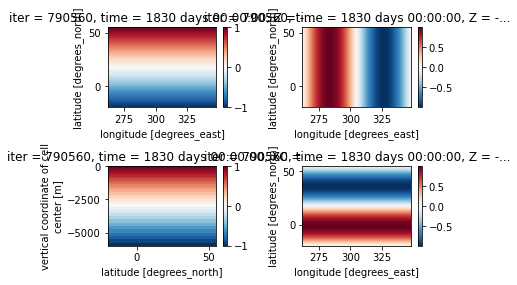

In [17]:
ones = xr.ones_like(ds.THETA.isel(time=0))
ptr0_3d = (ones*ptr0)
ptr1_3d = (ones*ptr1)
ptr2_3d = (ones*ptr2)
ptr3_3d = (ones*ptr3)
mask = (ds.maskC!=0.)

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_tight_layout(True)
ptr0_3d.isel(Z=10).plot(ax=axes[0,0])
ptr1_3d.isel(Z=10).plot(ax=axes[0,1])
ptr2_3d.isel(XC=10).plot(ax=axes[1,0])
ptr3_3d.isel(Z=10).plot(ax=axes[1,1])

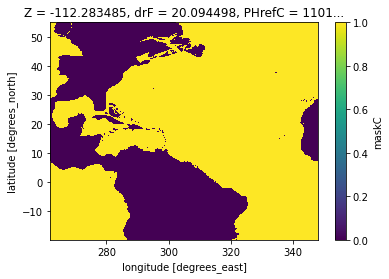

In [16]:
mask.isel(Z=10).plot()

In [18]:
ptr0_3d.values.reshape(np.prod(ds.THETA.isel(time=0).shape)).astype(tp).tofile(op.join(tdgs, 'ptracer-inputs/ptr0.bin'))
ptr1_3d.values.reshape(np.prod(ds.THETA.isel(time=0).shape)).astype(tp).tofile(op.join(tdgs, 'ptracer-inputs/ptr1.bin'))
ptr2_3d.values.reshape(np.prod(ds.THETA.isel(time=0).shape)).astype(tp).tofile(op.join(tdgs, 'ptracer-inputs/ptr2.bin'))
ptr3_3d.values.reshape(np.prod(ds.THETA.isel(time=0).shape)).astype(tp).tofile(op.join(tdgs, 'ptracer-inputs/ptr3.bin'))
mask.values.reshape(np.prod(ds.THETA.isel(time=0).shape)).astype(tp).tofile(op.join(tdgs, 'ptracer-inputs/ptr_mask.bin'))

# Test outputs

In [7]:
ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/trash/'), 
                     grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                     prefix=['PTRACER01','PTRACER02','PTRACER03','PTRACER04'], 
                     delta_t=2e2, iters=790560
                    )
ds

<xarray.Dataset>
Dimensions:    (XC: 1000, XG: 1000, YC: 900, YG: 900, Z: 46, Zl: 46, Zp1: 47, Zu: 46, time: 1)
Coordinates: (12/33)
    iter       (time) int64 790560
  * time       (time) timedelta64[ns] 1830 days
  * XC         (XC) >f4 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.9 348.0
  * YC         (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * XG         (XG) >f4 262.0 262.0 262.1 262.2 ... 347.7 347.8 347.8 347.9
  * YG         (YG) >f4 -19.96 -19.87 -19.79 -19.71 ... 54.71 54.79 54.88 54.96
    ...         ...
    maskW      (Z, YC, XG) bool dask.array<chunksize=(46, 900, 1000), meta=np.ndarray>
    maskS      (Z, YG, XC) bool dask.array<chunksize=(46, 900, 1000), meta=np.ndarray>
    maskInC    (YC, XC) bool dask.array<chunksize=(900, 1000), meta=np.ndarray>
    rhoRef     (Z) >f4 1.021e+03 1.021e+03 1.021e+03 ... 1.044e+03 1.044e+03
    maskInW    (YC, XG) bool dask.array<chunksize=(900, 1000), meta=np.ndarray>
    maskInS    (YG, XC) bool dask.array<chunksize=(900, 1000), meta=np.ndarray>
Data variables:
    PTRACER03  (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 46, 900, 1000), meta=np.ndarray>
    PTRACER04  (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 46, 900, 1000), meta=np.ndarray>
    PTRACER01  (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 46, 900, 1000), meta=np.ndarray>
    PTRACER02  (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 46, 900, 1000), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/tank/chaocea...

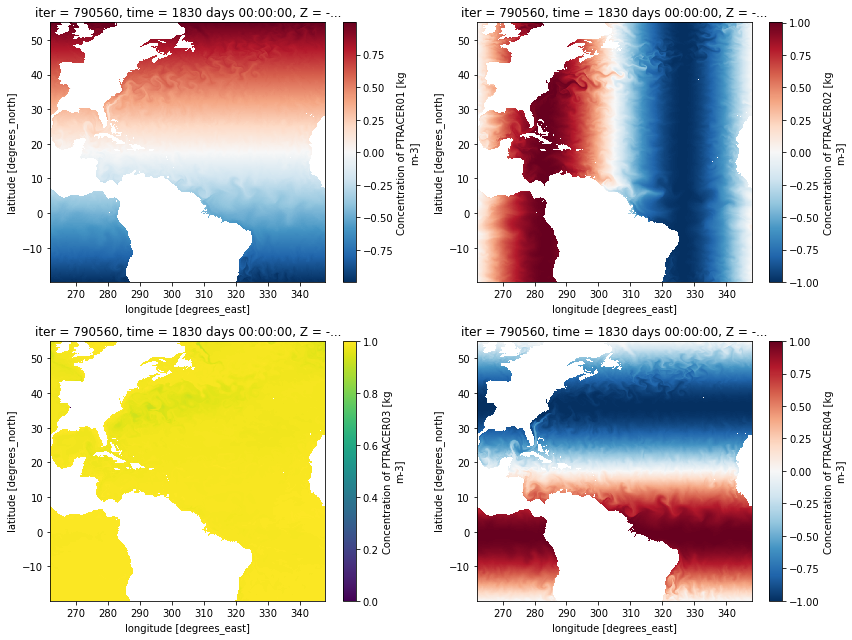

In [10]:
fig, axes = plt.subplots(figsize=(12,9), nrows=2, ncols=2)
fig.set_tight_layout(True)
ds.PTRACER01.where(ds.maskC!=0.).isel(time=-1,Z=0).plot(ax=axes[0,0])
ds.PTRACER02.where(ds.maskC!=0.).isel(time=-1,Z=0).plot(ax=axes[0,1])
ds.PTRACER03.where(ds.maskC!=0.).isel(time=-1,Z=0).plot(ax=axes[1,0])
ds.PTRACER04.where(ds.maskC!=0.).isel(time=-1,Z=0).plot(ax=axes[1,1])

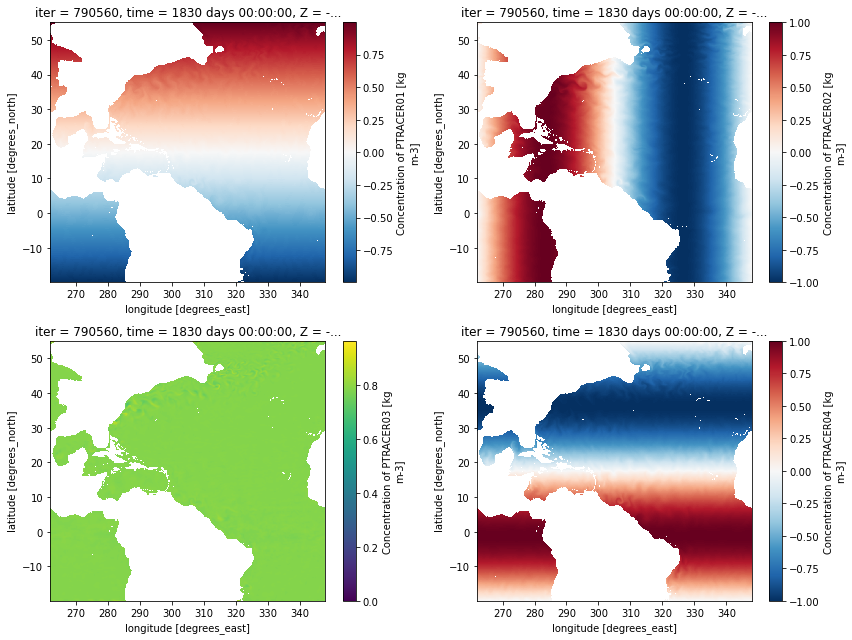

In [11]:
fig, axes = plt.subplots(figsize=(12,9), nrows=2, ncols=2)
fig.set_tight_layout(True)
ds.PTRACER01.where(ds.maskC!=0.).isel(time=-1,Z=20).plot(ax=axes[0,0])
ds.PTRACER02.where(ds.maskC!=0.).isel(time=-1,Z=20).plot(ax=axes[0,1])
ds.PTRACER03.where(ds.maskC!=0.).isel(time=-1,Z=20).plot(ax=axes[1,0])
ds.PTRACER04.where(ds.maskC!=0.).isel(time=-1,Z=20).plot(ax=axes[1,1])

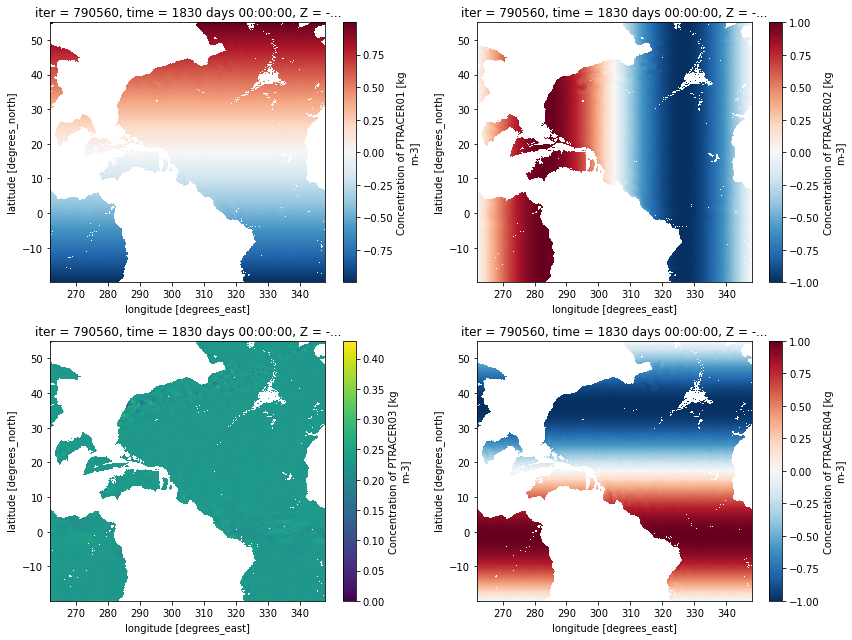

In [13]:
fig, axes = plt.subplots(figsize=(12,9), nrows=2, ncols=2)
fig.set_tight_layout(True)
ds.PTRACER01.where(ds.maskC!=0.).isel(time=-1,Z=30).plot(ax=axes[0,0])
ds.PTRACER02.where(ds.maskC!=0.).isel(time=-1,Z=30).plot(ax=axes[0,1])
ds.PTRACER03.where(ds.maskC!=0.).isel(time=-1,Z=30).plot(ax=axes[1,0])
ds.PTRACER04.where(ds.maskC!=0.).isel(time=-1,Z=30).plot(ax=axes[1,1])

In [7]:
80/1024*50e3*1e-3

3.90625